In [1]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
from scipy.integrate import solve_ivp

### データを読み込む
- データ元：京都大学生存圏研究所のサイト内にある，「[解析値を中心に再構成したNetCDFデータ](http://database.rish.kyoto-u.ac.jp/arch/jmadata/gpv-netcdf.html)」からダウンロードしました。
- ファイル場所：[MSM-P/2023/](http://database.rish.kyoto-u.ac.jp/arch/jmadata/data/gpv/netcdf/MSM-P/2023/)1214.nc
- `1214.nc`は100MB以上あるので，必要なデータのみを抽出して`1214_temp_rh.nc`として保存しました。

In [2]:
data = xr.open_mfdataset('./1214_temp_rh.nc').load()
data

<xarray.Dataset>
Dimensions:  (time: 8, p: 16, lat: 253, lon: 241)
Coordinates:
  * lon      (lon) float32 120.0 120.1 120.2 120.4 ... 149.6 149.8 149.9 150.0
  * lat      (lat) float32 47.6 47.5 47.4 47.3 47.2 ... 22.8 22.7 22.6 22.5 22.4
  * p        (p) float32 1e+03 975.0 950.0 925.0 ... 250.0 200.0 150.0 100.0
  * time     (time) datetime64[ns] 2023-12-14 ... 2023-12-14T21:00:00
Data variables:
    temp     (time, p, lat, lon) float64 252.9 251.7 251.5 ... 194.4 194.4 194.6
    rh       (time, p, lat, lon) float64 34.06 39.19 40.4 ... 75.0 75.0 75.0
Attributes:
    Conventions:  CF-1.0
    history:      created by create_1daync_msm_p.rb  2023-12-15

In [3]:
# 指定日時・指定位置の気温・相対湿度を取得
TIME = '2023-12-14T00:00:00'  # UTC
LAT = 36 + 3.5/60
LON = 140 + 7.5/60

temp = data['temp'].sel(time=TIME, lat=LAT, lon=LON, method='nearest')
rh = data['rh'].sel(time=TIME, lat=LAT, lon=LON, method='nearest')

In [4]:
# 定数
T0 = 273.15
Rv = 8.31 / 18.015e-3
e0 = 6.11
L = 2.5e6
Rd = 287
Cp = 1004
eps = Rd/Rv

### 乾燥断熱線（等温位線）を描く

$$
\begin{align}
\theta(p,T) &= T\left(\frac{1000}{p}\right)^{R/C_p}\\
\iff T(p,\theta) &= \theta\left(\frac{p}{1000}\right)^{R/C_p}
\end{align}
$$

In [5]:
def T(p,theta):
    '''温位と圧力から気温を計算する'''
    global Rd, Cp
    return theta*(p/1000)**(Rd/Cp)

### 湿潤断熱線を描く

$$
\begin{align}
\frac{dT}{dP} &= \frac{\frac{R_dT}{C_p} + \frac{Lq_s}{C_p}}{P(1 + \frac{\epsilon L^2 q_s}{C_p R_d T^2})}\\
q_s(P,T) &= \epsilon\frac{e_s(T)}{P - e_s(T)}\\
e_s(T) &= e_{s0}\exp\left(\frac{L}{R_v}\left(\frac{1}{T_0} - \frac{1}{T}\right)\right) \quad\iff\quad T=\frac{1}{\frac{1}{T_0} - \frac{R_v}{L}\log\frac{e_{s}RH/100}{e_{s0}}}\\
\epsilon &= \frac{R_d}{R_v}
\end{align}
$$

参考：http://fnorio.com/0152adiabatic_lapse_rate/adiabatic_lapse_rate.html


In [6]:
def es(T):
    '''飽和水蒸気圧'''
    global e0, L, Rv, T0
    return e0 * np.exp((L/Rv) * (1/T0 - 1/T))

def T_dew(T,rh):
    '''露点温度'''
    e = 0.01*rh * es(T)
    return 1/(1/T0 - Rv/L * np.log(e/e0))

def P(T,qs):
    '''気温と混合比から圧力を計算する'''
    global eps
    return es(T)*(eps + qs) / qs

def qs(p,T):
    '''飽和混合比'''
    global eps
    return eps * es(T) / (p - es(T))

def dTdp(p,T):
    '''気温の鉛直勾配(湿潤大気)'''
    global Rd, Cp, L, eps
    return (Rd*T + L*qs(p,T)) / (p*Cp*(1 + eps*L**2*qs(p,T)/(Cp*Rd*T**2)))

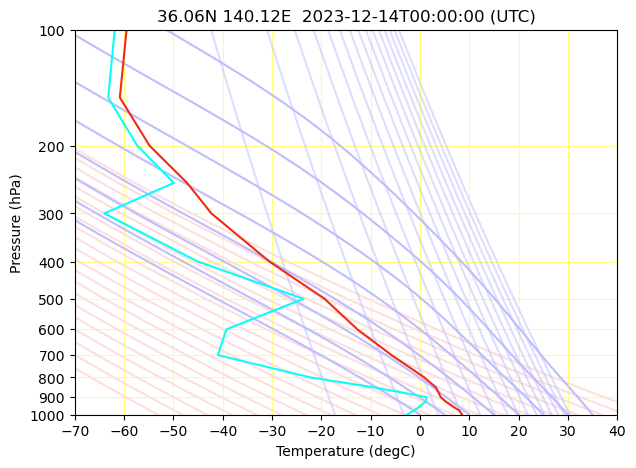

In [14]:
plt.figure(figsize=(7, 5))

# 乾燥断熱線（等温位線）
for theta in np.arange(220, 325, 5):
    plt.plot(T(temp.p, theta)-T0, np.log10(temp.p), color='#fededf')

# 湿潤断熱線
for T_ in np.arange(0+T0, 40+T0, 5):
    sol = solve_ivp(dTdp, t_span=[1000,100], y0=[T_], t_eval=np.linspace(1000,100))
    plt.plot(sol.y[0]-T0, np.log10(sol.t), color='#bdbdff')

# 等飽和混合比線
for qs_ in np.arange(0.001, 0.03, 0.002):
    T_ = np.arange(-70, 40, 0.1)
    plt.plot(T_, np.log10(P(T_+T0, qs_)), color='#bdbdff', alpha=0.5)

# 露点温度
plt.plot(T_dew(temp, rh)-T0, np.log10(temp.p), color='#09fefb')

# 状態曲線
plt.plot(temp-T0, np.log10(temp.p), color='#ef2a15')

plt.xlim(-70, 40)
plt.ylim(np.log10(100), np.log10(1000))
plt.xticks(np.arange(-70, 41, 10))
plt.yticks(np.log10(np.arange(100, 1100, 100)), np.arange(100, 1100, 100))
plt.xlabel('Temperature (degC)')
plt.ylabel('Pressure (hPa)')
plt.title(f'{LAT:.2f}N {LON:.2f}E  {TIME} (UTC)')
plt.grid(color='#ffff7a')
plt.gca().invert_yaxis()
plt.show()